In [88]:
import os
import cv2
import spacy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [3]:
def convert_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
nlp = spacy.load('en')
caption_file = '../data/raw/labeledCaptions.mat'
labels = loadmat(caption_file)
details = labels['captions']

In [5]:
haarCascade = '../../opencv-3.3.1/data/haarcascades/haarcascade_frontalface_alt.xml'
faceDetector = cv2.CascadeClassifier(haarCascade)

In [6]:
cleaned_details = []
for i in range(np.shape(details)[1]):
    #print(details[:,i])
    cleaned_details.append(str(details[:,i].tolist()).split('dtype')[0][:-30])

In [7]:
cleaned_captions={}
for i in range(np.shape(cleaned_details)[0]):
    cap = str(cleaned_details[i])
    doc = nlp(str(cap))
    people = []
    dates=[]
    for ent in doc.ents:
        if ent.label_=='PERSON' and len(ent.text) > 2:
            name = ent.text
            if name[0]=="'" or name[0]=="\"":
                name=name[1:]
            if name[-1]=="'" or name[-1]=="\"":
                name=name[-1]
            if not name.startswith("array") and len(name)>2:
                people.append(name)
    cap2 = str(details[:,i])
    img_name = cap2.split('.jpg')[0].split('array([\'20')[1]
    if img_name[:2]=='03'and img_name[3:5] in ['01','02','03']:
        cleaned_captions[str(img_name)] = np.unique(people)

In [80]:
correctly_detected_clean = {}
correct_positions_clean = {}
for key, value in cleaned_captions.items():
    people = value
    img_path = "../data/raw/%s.jpg"%key[3:]
    img = cv2.imread(img_path)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceDetector.detectMultiScale(img_grey, 1.3, 5)
    posns=[]
    for x,y,w,h in faces:
        posns.append([x,y,w,h])
        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    ground_truth_names =  [name for name in value if str(" ") in name] 
    if len(ground_truth_names)==len(faces):
        correctly_detected_clean[key] = value
        correct_positions_clean[key] = posns

KeyboardInterrupt: 

In [79]:
for key in correctly_detected_clean:
    face_locs = correct_positions_clean[key]
    if len(face_locs) > 0:
        for face_loc in face_locs:
            img = cv2.imread('../data/raw/%s.jpg'%key)
            cropped_face = img[face_log]
            

[[75, 108, 181, 181]]
[[31, 75, 243, 243]]
[[114, 61, 144, 144]]
[[91, 74, 138, 138]]
[[84, 62, 205, 205]]
[[87, 61, 95, 95]]
[[120, 26, 75, 75]]
[[72, 58, 106, 106]]
[[156, 36, 82, 82], [244, 32, 74, 74]]
[[130, 100, 98, 98]]
[[121, 78, 77, 77]]
[[151, 49, 104, 104]]
[]
[[93, 80, 156, 156]]
[[92, 213, 155, 155]]
[]
[[158, 43, 88, 88]]
[]
[]
[[103, 58, 86, 86]]
[[96, 76, 113, 113]]
[[75, 86, 190, 190]]
[[81, 45, 108, 108]]
[[34, 282, 115, 115]]
[]
[[118, 61, 99, 99]]
[[181, 65, 107, 107]]
[[165, 69, 73, 73]]
[[43, 64, 91, 91]]
[[20, 38, 144, 144], [119, 115, 125, 125]]
[[107, 117, 135, 135]]
[[153, 62, 72, 72]]
[[121, 78, 139, 139]]
[[59, 65, 190, 190]]
[[238, 45, 86, 86]]
[[19, 170, 78, 78], [175, 139, 85, 85]]
[[191, 50, 80, 80]]
[[161, 106, 125, 125]]
[]
[[98, 45, 77, 77]]
[[100, 85, 100, 100]]
[[119, 30, 201, 201]]
[[54, 83, 230, 230]]
[[129, 49, 126, 126]]
[[90, 101, 154, 154]]
[[240, 25, 63, 63], [76, 36, 64, 64]]
[[83, 41, 112, 112]]
[[135, 46, 131, 131]]
[[51, 118, 195, 195]]
[

[[70, 53, 164, 164]]
[[120, 42, 90, 90]]
[[40, 84, 260, 260]]
[[160, 60, 80, 80]]
[]
[[57, 41, 81, 81]]
[[182, 42, 79, 79]]
[[114, 90, 138, 138]]
[[189, 78, 82, 82]]
[[150, 67, 114, 114]]
[[150, 39, 89, 89], [294, 86, 73, 73]]
[[94, 99, 91, 91]]
[[197, 47, 105, 105]]
[]
[[78, 43, 147, 147]]
[[110, 39, 131, 131]]
[[103, 96, 177, 177]]
[[104, 37, 106, 106]]
[[134, 37, 84, 84]]
[[132, 35, 64, 64], [88, 55, 48, 48]]
[[133, 59, 109, 109]]
[[76, 44, 96, 96]]
[[205, 55, 110, 110], [60, 80, 100, 100]]
[[63, 36, 159, 159]]
[[245, 44, 76, 76]]
[[76, 59, 189, 189]]
[[155, 72, 77, 77]]
[[51, 79, 147, 147]]
[[98, 49, 138, 138]]
[[37, 80, 143, 143]]
[[70, 51, 75, 75]]
[[74, 72, 157, 157]]
[[121, 56, 100, 100]]
[[187, 50, 114, 114]]
[[123, 79, 74, 74]]
[[188, 77, 81, 81]]
[[43, 24, 212, 212]]
[[136, 51, 109, 109]]
[[135, 27, 82, 82]]
[[113, 36, 82, 82]]
[[57, 38, 85, 85]]
[[80, 73, 238, 238]]
[[186, 130, 94, 94]]
[[69, 58, 126, 126]]
[[84, 48, 107, 107]]
[[76, 33, 111, 111]]
[[56, 76, 215, 215]]
[[23

In [141]:
names = correctly_detected_clean['03/01/14/img_46']
posns =correct_positions_clean['03/01/14/img_46']

Nathan Lane


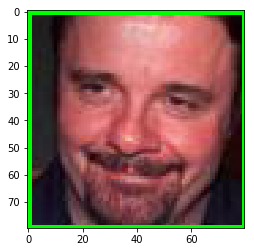

In [144]:
x,y,w,h = posns[1][0],posns[1][1],posns[1][2],posns[1][3]
face_extract = img[y:y+h, x:x+h]
plt.imshow(convert_to_rgb(face_extract))
print(names[1])

Leslie Moonves


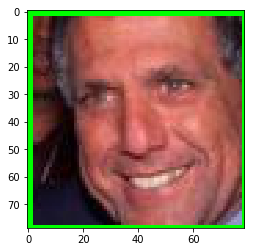

In [145]:
x2,y2,w2,h2 = posns[0][0],posns[0][1],posns[0][2],posns[0][3]
face_extract2 = img[y2:y2+h2, x2:x2+h2]
plt.imshow(convert_to_rgb(face_extract2))
print(names[0])

In [151]:
correct_extracts = {}
for key, value in correctly_detected_clean.items():
    names = correctly_detected_clean[key]
    posns = correct_positions_clean[key]
    img = cv2.imread('../data/raw/%s.jpg'%key[3:])
    for i in range(len(posns)):
        x,y,w,h = posns[i][0],posns[i][1],posns[i][2],posns[i][3]
        face_extract = img[y:y+h, x:x+h]
        name = names[i]
        correct_extracts[name] = face_extract

In [162]:
ar = correct_extracts.popitem()[1]
img3 = cv2.imread(np.array(ar))
plt.imshow(img3)

TypeError: bad argument type for built-in operation